# XGBoost


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
from tqdm import tqdm
import joblib

# Load the dataset
file_path = 'Datasets/data_NO2.csv'
data = pd.read_csv(file_path, delimiter=';')

# Convert datetime_utc to datetime and set as index
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data = data.set_index('datetime_utc')

# Add time-based features (hour, day of week, cyclical features)
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Add cyclical encoding for hours and days of the week
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Create lag features (past 48 and 72 hours)
data['lag_48'] = data['spot_price'].shift(48)
data['lag_72'] = data['spot_price'].shift(72)

# Drop rows with NaN values due to lagging
data = data.dropna()

# Define the number of hours to look back and forecast horizon
look_back = 24  # Use the past 24 hours as features
forecast_horizon = 24  # Predict the next 24 hours

# Function to create lagged features and future targets
def create_lagged_features(data, look_back, forecast_horizon):
    features, targets = [], []
    for i in range(look_back, len(data) - forecast_horizon):
        # Use past 'look_back' hours as features, including new time-based and lag features
        features.append(data.iloc[i-look_back:i].values.flatten())
        # Use next 'forecast_horizon' hours as targets
        targets.append(data['spot_price'].iloc[i:i+forecast_horizon].values)
    return np.array(features), np.array(targets)

# Create the features and targets
X, y = create_lagged_features(data[['spot_price', 'volume_demand', 'volume_production', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_48', 'lag_72']], look_back, forecast_horizon)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

# Hyperparameter tuning using Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    # Train on each output (24 hours ahead)
    models = []
    for i in tqdm(range(forecast_horizon), desc="Training models"):
        model = xgb.XGBRegressor(**param)
        model.fit(X_train_scaled, y_train[:, i])
        models.append(model)

    # Predict the next 24 hours
    y_pred = np.column_stack([m.predict(X_test_scaled) for m in models])

    # Evaluate the performance using MAE
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Save the study
joblib.dump(study, 'optuna_study.joblib')

# Train the final model using the best parameters from Optuna
best_params = study.best_params
final_models = []

for i in tqdm(range(forecast_horizon), desc="Training final models"):
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train_scaled, y_train[:, i])
    final_models.append(model)
    # Save each model
    joblib.dump(model, f'xgb_model_{i}.joblib')

# Predict the next 24 hours
y_pred = np.column_stack([m.predict(X_test_scaled) for m in final_models])

# Final evaluation
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Mean Absolute Error for 24-hour forecast: {final_mae}")
print(f"Final Root Mean Squared Error for 24-hour forecast: {final_rmse}")

# Save the evaluation results
with open('evaluation_results.txt', 'w') as f:
    f.write(f"Final Mean Absolute Error for 24-hour forecast: {final_mae}\n")
    f.write(f"Final Root Mean Squared Error for 24-hour forecast: {final_rmse}\n")


[I 2024-10-23 15:42:44,406] A new study created in memory with name: no-name-81392da1-3d44-4a1a-9a4b-14793e115caa
Training models: 100%|██████████| 24/24 [05:42<00:00, 14.26s/it]
[I 2024-10-23 15:48:27,015] Trial 0 finished with value: 5.680293282089266 and parameters: {'n_estimators': 852, 'learning_rate': 0.22376419917075666, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5955837482444414, 'colsample_bytree': 0.8984764280176822, 'reg_alpha': 0.3079184308484769, 'reg_lambda': 0.7116447537681492}. Best is trial 0 with value: 5.680293282089266.
Training models:   4%|▍         | 1/24 [00:46<17:57, 46.85s/it]
[W 2024-10-23 15:49:13,874] Trial 1 failed with parameters: {'n_estimators': 757, 'learning_rate': 0.19010528495861756, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9088459341767868, 'colsample_bytree': 0.8068924822328527, 'reg_alpha': 0.30456007866939583, 'reg_lambda': 0.42077753338556034} because of the following error: KeyboardInterrupt().
Traceback (most recent ca

KeyboardInterrupt: 

# TFT

In [25]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE
import torch

# Load the data
data = pd.read_csv("Datasets/data_NO2.csv", delimiter=";")

# Convert datetime to correct format and create an integer time index
data["datetime_utc"] = pd.to_datetime(data["datetime_utc"])
data["time_idx"] = ((data["datetime_utc"] - data["datetime_utc"].min()).dt.total_seconds() // 3600).astype(int)

# Add a pseudo group column since group_ids is required
data["group"] = 1  # Assign a constant value for all rows

# Parameters
max_encoder_length = 168  # past 7 days (hourly data)
max_prediction_length = 24  # predict next 24 hours

# Train/validation split based on time
training_cutoff = data["time_idx"].max() - max_prediction_length

# Prepare the TimeSeriesDataSet
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="spot_price",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_reals=[
        "volume_demand",
        "volume_production",
    ],
    time_varying_unknown_reals=["spot_price"],
    allow_missing_timesteps=True
)

# Create validation set
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Define callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger],
    limit_train_batches=50,
    enable_checkpointing=True,
)

# Train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Make predictions
predictions = tft.predict(val_dataloader)

/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'ad

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

# Prophet

15:34:18 - cmdstanpy - INFO - Chain [1] start processing
15:34:25 - cmdstanpy - INFO - Chain [1] done processing
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 5.391650557789908


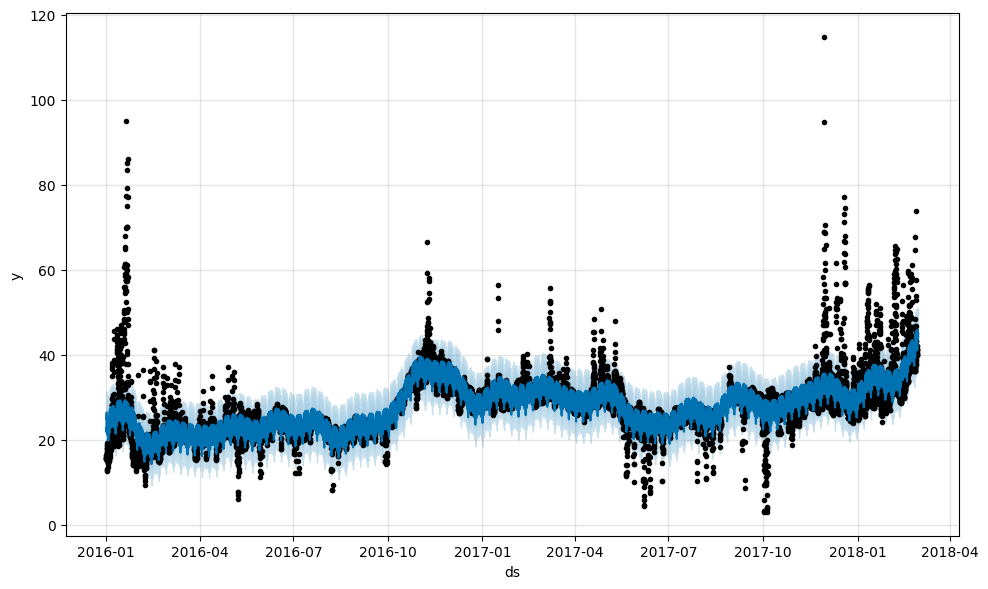

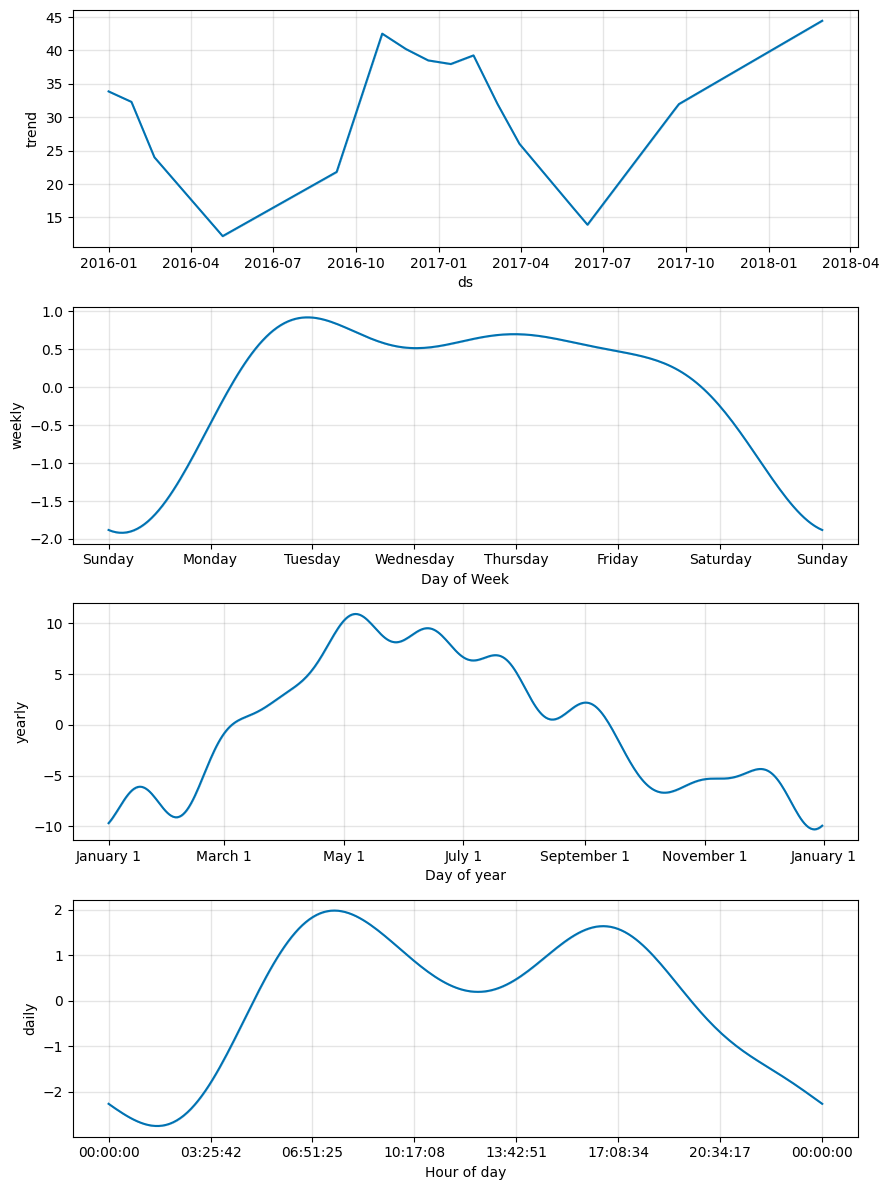

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'Datasets/data_NO2.csv'
data = pd.read_csv(file_path, delimiter=';')

# Convert datetime_utc to datetime and set as index
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'], utc=True).dt.tz_localize(None)
data = data.set_index('datetime_utc')

# Feature engineering: Add time-based features (hour, day of the week, etc.)
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Prepare the data for Prophet: Prophet requires a DataFrame with 'ds' (date) and 'y' (target)
# We need to reset the index and rename the columns for Prophet compatibility
df = data.reset_index()[['datetime_utc', 'spot_price']]
df.columns = ['ds', 'y']  # 'ds' for date, 'y' for target (spot price)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Initialize the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)

# Add seasonal components if needed (optional, Prophet handles this automatically)
# model.add_seasonality(name='daily', period=1, fourier_order=15)
# model.add_seasonality(name='weekly', period=7, fourier_order=5)

# Fit the model on the training data
model.fit(train_data)

# Create future dataframe for the next 24 hours
future = model.make_future_dataframe(periods=24, freq='H')

# Forecast the next 24 hours
forecast = model.predict(future)

# Select the predicted values (for the forecast horizon)
predicted_values = forecast[['ds', 'yhat']].tail(24)

# Evaluate the model using RMSE
# Since Prophet predicts beyond the training set, we will use the last 24 hours of the test data for evaluation
actual_values = test_data['y'].head(24).values
predicted_values = predicted_values['yhat'].values

# Compute RMSE
rmse = mean_squared_error(actual_values, predicted_values, squared=False)
print(f"Test RMSE: {rmse}")

# Optional: Plot forecast and actual values for visualization
model.plot(forecast)
model.plot_components(forecast)

# Optional: Save the model and predictions
forecast.to_csv('prophet_forecast.csv', index=False)


# Arima

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print("Loading and preprocessing data...")
# Load the dataset
file_path = 'Datasets/data_NO2.csv'
data = pd.read_csv(file_path, delimiter=';')

# Convert datetime_utc to datetime and set as index
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data = data.set_index('datetime_utc')

print("Performing feature engineering...")
# Feature engineering: Add time-based features (hour, day of the week, etc.)
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Add cyclical encoding for hours and days of the week (useful for ARIMA if trends are cyclic)
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Add lag features (e.g., past 48 and 72 hours spot price)
data['lag_48'] = data['spot_price'].shift(48)
data['lag_72'] = data['spot_price'].shift(72)

# Drop NaN values due to lagging
data = data.dropna()

print("Normalizing features...")
# Normalize the continuous features
scaler = StandardScaler()
data[['spot_price', 'volume_demand', 'volume_production']] = scaler.fit_transform(data[['spot_price', 'volume_demand', 'volume_production']])

# Prepare the target variable (spot_price) and feature matrix
features = data[['spot_price', 'volume_demand', 'volume_production', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_48', 'lag_72']]
target = data['spot_price']

# Walk-forward cross-validation parameters
initial_train_size = int(len(features) * 0.6)  # Start with 60% of data
test_size = 24  # Predict the next 24 hours
n_splits = (len(features) - initial_train_size) // test_size  # Number of cross-validation splits

# Store RMSE results
rmse_scores = []

print(f"Starting walk-forward validation with {n_splits} splits...")
# Walk-forward validation loop
for split in tqdm(range(n_splits), desc="Processing splits"):
    # Define the train and test indices for this fold
    train_end = initial_train_size + split * test_size
    test_end = train_end + test_size

    # Split the data into train and test
    train_features = features.iloc[:train_end]
    train_target = target.iloc[:train_end]
    test_features = features.iloc[train_end:test_end]
    test_target = target.iloc[train_end:test_end]

    # Fit the SARIMAX model with exogenous features (ARIMA with additional variables)
    model = SARIMAX(
        train_target,
        exog=train_features,  # Exogenous variables (the additional features)
        order=(5, 1, 2),      # ARIMA order (p,d,q)
        seasonal_order=(1, 1, 1, 24),  # Seasonal ARIMA (P,D,Q,S), with S=24 for daily cycle
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Fit the model on the training data
    model_fit = model.fit(disp=False)

    # Forecast the next 24 hours
    forecast = model_fit.get_forecast(steps=test_size, exog=test_features)
    forecast_values = forecast.predicted_mean

    # Calculate RMSE for this fold
    rmse = mean_squared_error(test_target, forecast_values, squared=False)
    rmse_scores.append(rmse)
    print(f"Fold {split+1}: Test RMSE = {rmse}")

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print(f"Average RMSE across all folds: {average_rmse}")


Loading and preprocessing data...
Performing feature engineering...
Normalizing features...
Starting walk-forward validation with 393 splits...


Processing splits:   0%|          | 0/393 [00:00<?, ?it/s]/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
Processing splits:   0%|          | 0/393 [02:20<?, ?it/s]


KeyboardInterrupt: 

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time

# Start timing the entire process
start_time = time.time()

print("Loading and preprocessing data...")
file_path = 'Datasets/data_NO2.csv'
data = pd.read_csv(file_path, delimiter=';')
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data = data.set_index('datetime_utc')

print("Performing feature engineering...")
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

print("Creating lag features...")
for i in tqdm(range(1, 73), desc="Creating lags"):
    data[f'lag_{i}'] = data['spot_price'].shift(i)

data = data.dropna()

print("Normalizing features...")
scaler = StandardScaler()
data[['spot_price', 'volume_demand', 'volume_production']] = scaler.fit_transform(data[['spot_price', 'volume_demand', 'volume_production']])

# Prepare features and target
features = data[['spot_price', 'volume_demand', 'volume_production', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'] + [f'lag_{i}' for i in range(1, 73)]]
target = data['spot_price']

# Split data into train and test
train_size = len(features) - 24  # Use all data except last 24 hours for training
train_features = features.iloc[:train_size]
train_target = target.iloc[:train_size]
test_features = features.iloc[train_size:]
test_target = target.iloc[train_size:]

# Replace the model fitting part with this:
print("Fitting SARIMAX model...")
fit_start_time = time.time()
model = SARIMAX(
    train_target,
    exog=train_features,
    order=(5, 1, 2),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False, callback=lambda x: print(f"Iteration: {x['iteration']}, Log-likelihood: {x['llf']:.2f}"))
fit_end_time = time.time()

print(f"Model fitting took {fit_end_time - fit_start_time:.2f} seconds")
print("Forecasting next 24 hours...")
forecast_start_time = time.time()
forecast = model_fit.get_forecast(steps=24, exog=test_features)
forecast_values = forecast.predicted_mean
forecast_end_time = time.time()
print(f"Forecasting took {forecast_end_time - forecast_start_time:.2f} seconds")

# Check for NaN values
print("\nChecking for NaN values:")
print(f"NaN values in test_target: {test_target.isna().sum()}")
print(f"NaN values in forecast_values: {forecast_values.isna().sum()}")

# Remove NaN values for RMSE calculation
valid_indices = ~(test_target.isna() | forecast_values.isna())
test_target_valid = test_target[valid_indices]
forecast_values_valid = forecast_values[valid_indices]

# Calculate RMSE
if len(test_target_valid) > 0:
    rmse = mean_squared_error(test_target_valid, forecast_values_valid, squared=False)
    print(f"\nTest RMSE: {rmse}")
else:
    print("\nUnable to calculate RMSE due to insufficient valid data points")

# Print actual vs predicted values
print("\nActual vs Predicted values:")
comparison = pd.DataFrame({'Actual': test_target, 'Predicted': forecast_values})
print(comparison)

# Print information about any discarded data points
print(f"\nNumber of data points used for RMSE calculation: {len(test_target_valid)}")
print(f"Number of data points discarded due to NaN: {len(test_target) - len(test_target_valid)}")

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

Loading and preprocessing data...
Performing feature engineering...
Creating lag features...


Creating lags: 100%|██████████| 72/72 [00:00<00:00, 6603.61it/s]

Normalizing features...
Fitting SARIMAX model...



/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitting took 2423.94 seconds
Forecasting next 24 hours...
Forecasting took 0.02 seconds


/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/andersrodem/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: Input contains NaN.